## Importing Libraries


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/stockdt/")


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import plotly.express as px


from sklearn.preprocessing import MinMaxScaler , StandardScaler

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, GRU
plt.style.use('fivethirtyeight')
from keras.layers import GlobalMaxPooling1D, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## Read Data

In [ ]:
# import os
# os.chdir("/content/drive/MyDrive/stockdt/")
def get_data(ticker, start= "2008-12-01",end="2023-01-1"):
  path = f'./Data/{ticker}.csv'
  start_date = pd.to_datetime(start)
  end_date = pd.to_datetime(end)
  price_data = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
  price_data = price_data.loc[(price_data.index >= start_date) & (price_data.index <= end_date)]
  return price_data


In [ ]:
import yfinance as yf
import pandas as pd
name = "NAHARSPING"
data = yf.download(f'{name}.NS',period='730d', interval="1h")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
len(data)

5074

In [ ]:
data = data.drop(data.index[0])
data = data[["Adj Close"]]

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df = data.copy().astype(float)
# df.drop(["Close","Volume"] , axis = 1, inplace=True)
df


,Adj Close
Datetime,
2021-02-12 10:15:00+05:30,79.099998
2021-02-12 11:15:00+05:30,79.150002
2021-02-12 12:15:00+05:30,79.500000
2021-02-12 13:15:00+05:30,79.000000
2021-02-12 14:15:00+05:30,78.300003
...,...
2024-01-24 11:15:00+05:30,288.350006
2024-01-24 12:15:00+05:30,288.799988
2024-01-24 13:15:00+05:30,296.500000


In [ ]:

df_scaled = scaler.fit_transform(df)
df_for_training_df = df_scaled[:4000]
df_for_val_df = df_scaled[4000:4500]
df_for_test_df = df_scaled[4500:]
# df_for_training = df_for_training.astype(float)




In [ ]:
df_for_training_df

array([[0.00241525],
       [0.00249854],
       [0.00308153],
       ...,
       [0.32381109],
       [0.32372782],
       [0.32306156]])

In [ ]:
#Empty lists to be populated using formatted training data

n_future = 3   # Number of days we want to look into the future based on the past days.
n_past = 60  # Number of past days we want to use to predict the future.
label_idx = 0 #
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
def create_dataset(df):
  trainX = []
  trainY = []
  for i in range(n_past, len(df) - n_future +1):
      trainX.append(df[i - n_past:i, 0:df.shape[1]])
      trainY.append(df[i + n_future - 1:i + n_future, label_idx])
  return trainX, trainY
trainX, trainY = create_dataset(df_for_training_df)
trainX, trainY = np.array(trainX), np.array(trainY)

validX, validY = create_dataset(df_for_val_df)
validX, validY = np.array(validX), np.array(validY)

testX, testY = create_dataset(df_for_test_df)
testX, testY = np.array(testX), np.array(testY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (3938, 60, 1).
trainY shape == (3938, 1).


In [ ]:
validY.shape

(493, 1)

In [ ]:
df.isna().any()

Open         False
High         False
Low          False
Adj Close    False
dtype: bool

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5077 entries, 2021-02-10 09:15:00+05:30 to 2024-01-19 15:15:00+05:30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5077 non-null   float64
 1   High       5077 non-null   float64
 2   Low        5077 non-null   float64
 3   Close      5077 non-null   float64
 4   Adj Close  5077 non-null   float64
 5   Volume     5077 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 277.6 KB


In [ ]:
df.shape

(5077, 6)

In [ ]:
df.duplicated().sum()

0

## Set time as index


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-02-10 09:15:00+05:30,82.400002,82.400002,79.550003,79.599998,79.599998,0
2021-02-10 10:15:00+05:30,79.050003,80.000000,77.900002,79.500000,79.500000,7774
2021-02-10 11:15:00+05:30,80.199997,80.699997,80.000000,80.050003,80.050003,3551
2021-02-10 12:15:00+05:30,80.099998,80.349998,80.000000,80.000000,80.000000,53
2021-02-10 13:15:00+05:30,80.000000,80.050003,79.550003,80.000000,80.000000,2381
...,...,...,...,...,...,...
2024-01-19 11:15:00+05:30,306.049988,307.000000,301.649994,302.799988,302.799988,85009
2024-01-19 12:15:00+05:30,302.600006,305.399994,299.850006,304.000000,304.000000,48151
2024-01-19 13:15:00+05:30,303.549988,307.450012,301.000000,303.950012,303.950012,43767


In [ ]:
# df['time'] = pd.to_datetime(df['Date'])
# df.set_index('time',inplace=True)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-02-10 09:15:00+05:30,82.400002,82.400002,79.550003,79.599998,79.599998,0
2021-02-10 10:15:00+05:30,79.050003,80.000000,77.900002,79.500000,79.500000,7774
2021-02-10 11:15:00+05:30,80.199997,80.699997,80.000000,80.050003,80.050003,3551
2021-02-10 12:15:00+05:30,80.099998,80.349998,80.000000,80.000000,80.000000,53
2021-02-10 13:15:00+05:30,80.000000,80.050003,79.550003,80.000000,80.000000,2381


## Data Visualization

In [ ]:
fig = px.line(x=df.index[2800+14:3400],y=validY[:,0])
fig.show()

In [ ]:
validY.shape

(586, 1)

In [ ]:
df.index.min()

In [ ]:
df.index.max()


Timestamp('2024-01-19 15:15:00+0530', tz='Asia/Kolkata')

In [ ]:
dataset = df.filter(['Adj Close'])

data = dataset.values

data = data.reshape(-1,1)

## Data Normalizing and spliting

In [ ]:

data = scaler.fit_transform(data)
train_set = int(len(data)*0.8)
test_set = train_set - len(data)
train, test = data[0:train_set,:], data[train_set:len(data),:]

In [ ]:

def create_dataset(dataset, predictiontime):

    dataX, dataY = [],[]

    for i in range(predictiontime,dataset.shape[0]):
        dataX.append(dataset[i - predictiontime : i, 0])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train, 60)
x_test, y_test = create_dataset(test,60)


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [ ]:
x_train.shape

(4001, 60, 1)

In [ ]:
x_test.shape

(956, 60, 1)

## Create and fit LSTM model

In [ ]:
# model = Sequential()
# model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=96, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=96, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=96))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:

model = Sequential()
model.add(Bidirectional(GRU(units=200, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]))))
model.add(Dropout(0.2))
# model.add(Bidirectional(GRU(units=200, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True,)))
# model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
test_predict = model.predict(testX)
print(test_predict.shape)
model.summary()

19/19 [==============================] - 3s 4ms/step
(600, 1)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 7, 128)            27264     
 onal)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 7, 128)            0         
                                                                 
 lstm_14 (LSTM)              (None, 7, 128)            131584    
                                                                 
 dropout_30 (Dropout)        (None, 7, 128)            0         
                                                                 
 lstm_15 (LSTM)              (None, 256)               394240    
                                                                 
 dropout_31 (Dropout)        (None, 256)               0  

In [ ]:
model= Sequential()
model.add(Bidirectional(GRU(units=200, return_sequences=True,  input_shape=(trainX.shape[1], trainX.shape[2]))))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(units=200, return_sequences=True, )))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# checkpoint = ModelCheckpoint("Naharspining_gru.wt",
#                     monitor="val_loss", mode="min",
#                     save_best_only=True, verbose=1)

model.fit(trainX,trainY,epochs=100, batch_size=16 , validation_data=(validX, validY), callbacks=[early_stopping,checkpoint])
model.load_weights("Naharspining_gru.wt")
test_predict = model.predict(testX)

Epoch 1/100
246/247 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 1: val_loss did not improve from 0.00004
247/247 [==============================] - 6s 26ms/step - loss: 0.0011 - val_loss: 5.5035e-04
Epoch 2/100
247/247 [==============================] - ETA: 0s - loss: 0.0011
Epoch 2: val_loss did not improve from 0.00004
247/247 [==============================] - 6s 23ms/step - loss: 0.0011 - val_loss: 6.5540e-05
Epoch 3/100
246/247 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 3: val_loss did not improve from 0.00004
247/247 [==============================] - 6s 26ms/step - loss: 0.0013 - val_loss: 5.2494e-04
Epoch 4/100
246/247 [============================>.] - ETA: 0s - loss: 8.9282e-04
Epoch 4: val_loss did not improve from 0.00004
247/247 [==============================] - 6s 23ms/step - loss: 8.9279e-04 - val_loss: 4.4004e-05
Epoch 5/100
245/247 [============================>.] - ETA: 0s - loss: 9.4887e-04
Epoch 5: val_loss did not improve 

In [ ]:
test_predict = model.predict(validX).reshape(-1)
# test_predict = scaler.inverse_transform(np.tile(test_predict, df_for_training_df.shape[1]))[:,0]
# valid_pred = model.predict(validX)
# y_test_copy = np.tile(valid_pred, df_for_training_df.shape[1])
y_test_scaled = validY.reshape(-1)


16/16 [==============================] - 0s 4ms/step


In [ ]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(np.tile(test_predict, df_for_training_df.shape[1]))[:,0]
y_test_copy = np.tile(testY, df_for_training_df.shape[1]) #np.repeat(testY, df_for_training_df.shape[1], axis=-1)
y_test_scaled = scaler.inverse_transform(y_test_copy)[:,0]

17/17 [==============================] - 0s 10ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_scaled, test_predict)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Display the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 38.146853679793814
Root Mean Squared Error (RMSE): 6.176313923352165


 ## Visualizing the prediction of the neural network

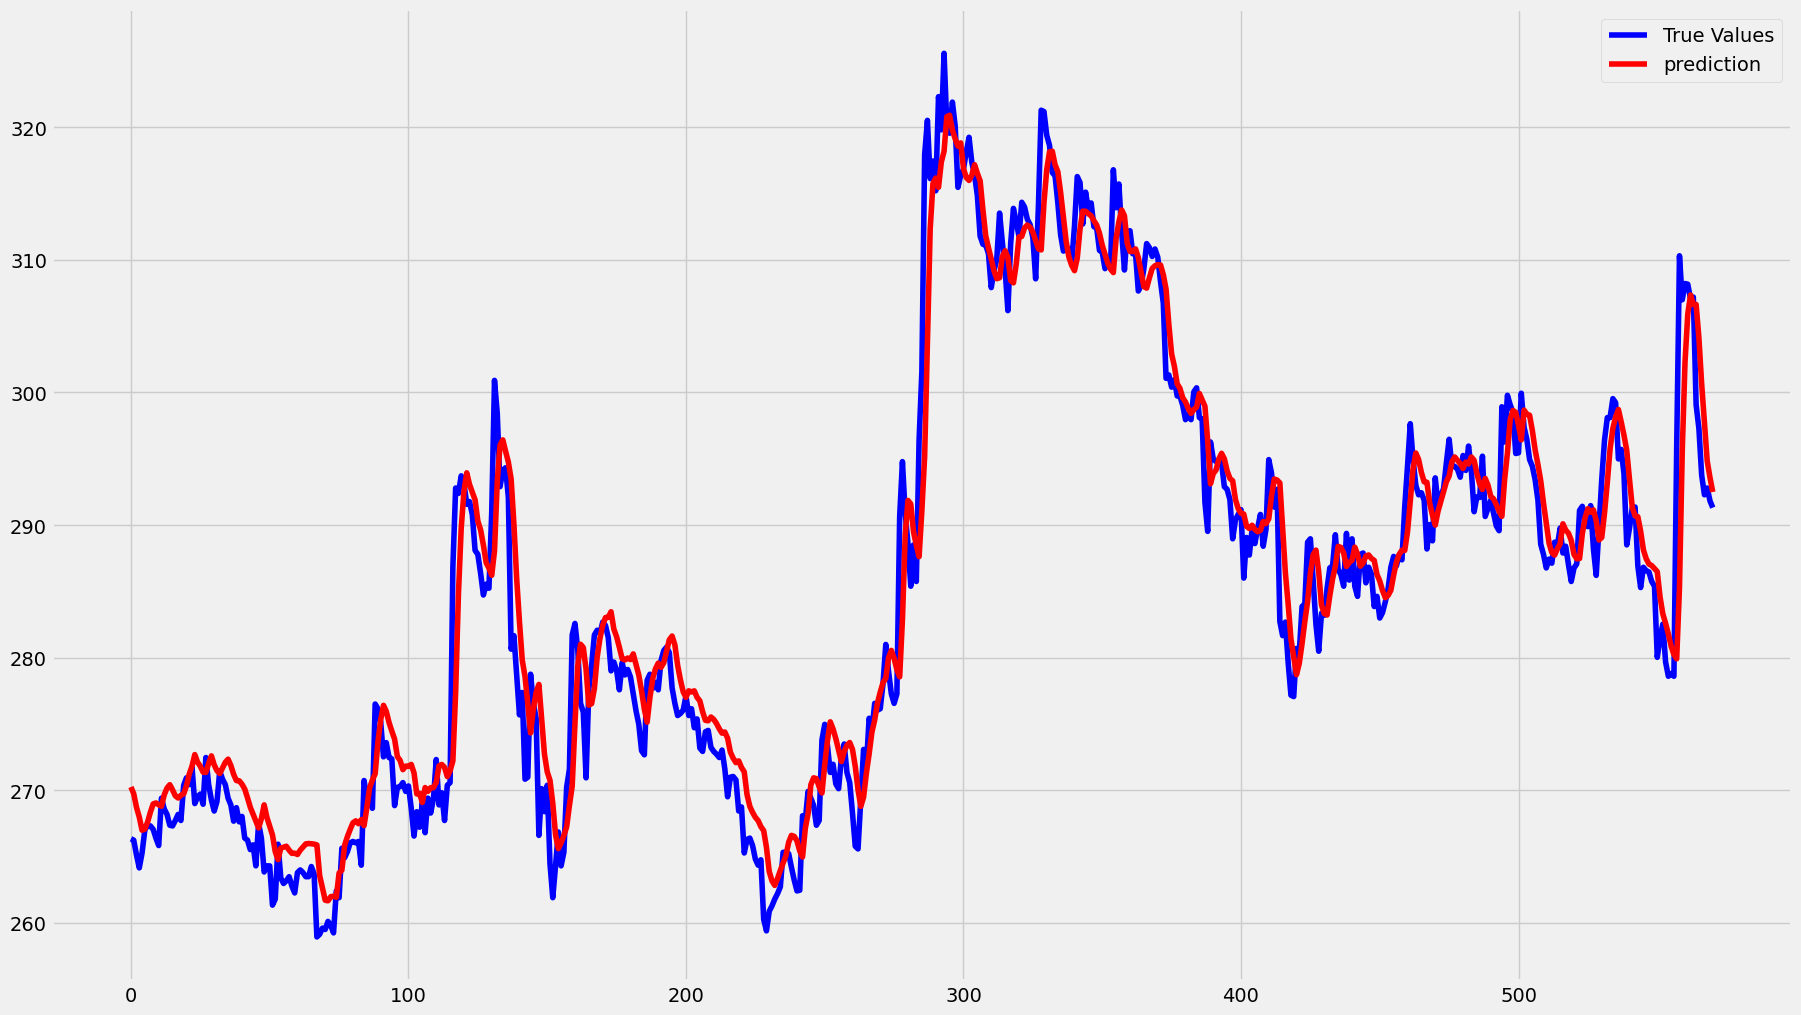

In [ ]:

fig, ax = plt.subplots(figsize=(20,12))

ax.plot(y_test_scaled, color='blue', label='True Values')
plt.plot(test_predict, color='red',label='prediction')
plt.legend()
plt.show()

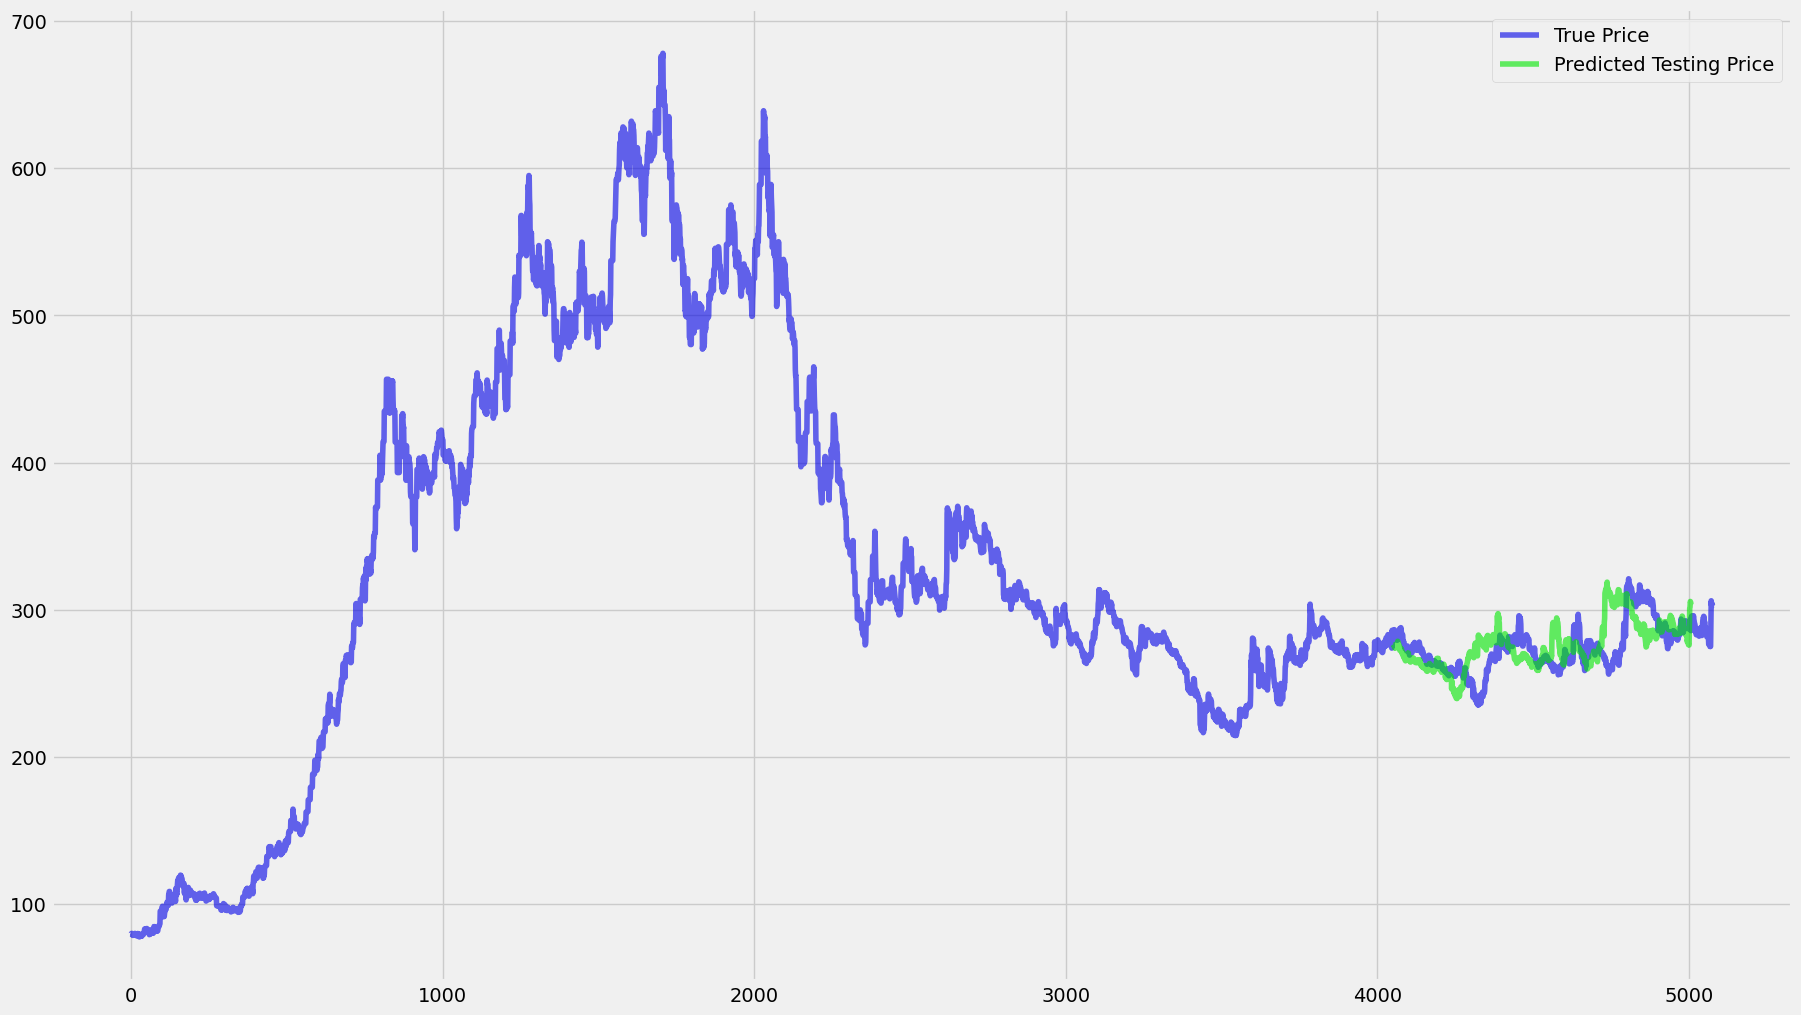

In [ ]:
fig, ax2 = plt.subplots(figsize=(20, 12))
plt.plot(df['Close'].values, color=(0, 0, 0.9, 0.6), label="True Price")
ax2.plot(range(len(y_train) + 50, len(y_train) + 50 + len(test_predict)), test_predict, color=(0, 0.9, 0,0.6),
             label='Predicted Testing Price')
plt.legend()